ML Course, Bogotá, Colombia  (&copy; Josh Bloom; June 2019)

In [145]:
%run ../talktools.py

<Figure size 432x288 with 0 Axes>

<img src="http://www.asimovinstitute.org/wp-content/uploads/2016/09/neuralnetworks.png">

Source: http://www.asimovinstitute.org/neural-network-zoo/

<img src="https://www.evernote.com/l/AUU9p3_1J5NJX61cCzZPOPc76jm68et-pUgB/image.png">

Source: http://www.wsdm-conference.org/2016/slides/WSDM2016-Jeff-Dean.pdf
This is a good, high-level overview of what's important/current in DNNs.

### Some references/Statements

- "Deep learning" (Nature 2015) http://www.nature.com/nature/journal/v521/n7553/full/nature14539.html

- "HYPING ARTIFICIAL INTELLIGENCE, YET AGAIN" http://www.newyorker.com/tech/elements/hyping-artificial-intelligence-yet-again

- *"Creating a deep learning model is, ironically, a highly manual process. Training a model takes a long time, and even for the top practitioners, it is a hit or miss affair where you don’t know whether it will work until the end. No mature tools exist to ensure models train successfully, or to ensure that the original set up is done appropriately for the data."* -- J. Howard (Fast.ai; http://www.fast.ai/2016/10/07/fastai-launch/)

## Convolutional Neural Nets (ConvNets)

NNs built for images (or more generally, inputs with spatial structure).

### Key Ideas: 
  - layers see only parts of each image (effectively all other weights are zero).
  - some layers do simple operations on previous layers to reduce dimensionality (e.g., take the largest value in a a 3x3 range)
  - "Every Layer has a simple API: It transforms an input 3D volume to an output 3D volume with some differentiable function that may or may not have parameters."
 
<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg">

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg">

"An example input volume in red (e.g. a 32x32x3 CIFAR-10 image), and an example volume of neurons in the first Convolutional layer. Each neuron in the convolutional layer is connected only to a local region in the input volume spatially, but to the full depth (i.e. all color channels). Note, there are multiple neurons (5 in this example) along the depth, all looking at the same region in the input - see discussion of depth columns in text below. "

cf. http://cs231n.github.io/convolutional-networks/

<img src="http://www.nature.com/nature/journal/v521/n7553/images/nature14539-f2.jpg">
Source: http://www.nature.com/nature/journal/v521/n7553/fig_tab/nature14539_F2.html

### Filter banks

  http://setosa.io/ev/image-kernels/

### Pooling

<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" width="40%">
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width="40%">
Source: http://cs231n.github.io/convolutional-networks/

In [1]:
import datetime, os

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras import backend as K
import tensorflow as tf

# Print keras version
print(tensorflow.keras.__version__)

2.2.4-tf


In [2]:
from tensorflow.keras.utils import to_categorical

fashion_mnist = tf.keras.datasets.fashion_mnist

nb_classes = 10
batch_size = 128


(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)
input_shape

(28, 28, 1)

In [3]:
Y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
# add with tf.device('/gpu:0'): if on GPU

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))


model.add(Conv2D(64, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))


model.add(Conv2D(128, (3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(rate=0.1))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

# Dropout
model.add(Dropout(rate=0.5))
    
model.add(Dense(32, activation='relu'))
    

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_5 (Activation)    (None, 11, 11, 64)       

In [10]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'nn_results/colombia_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'nn_results/training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit(x=x_train.reshape(-1,28,28,1), 
          y=Y_train, 
          epochs=20,
          batch_size=batch_size,
          validation_data=(x_test.reshape(-1,28,28,1), Y_test), 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... nn_results/colombia_nn_2019-06-06T04:00.h5
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.6719 - accuracy: 0.7578

W0605 23:01:43.559432 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:01:43.560703 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:01:43.561464 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 59s 978us/sample - loss: 0.6715 - accuracy: 0.7579 - val_loss: 0.4494 - val_accuracy: 0.8439
Epoch 2/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.4092 - accuracy: 0.8559

W0605 23:02:38.601661 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:02:38.602554 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:02:38.603157 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 55s 917us/sample - loss: 0.4091 - accuracy: 0.8558 - val_loss: 0.3348 - val_accuracy: 0.8782
Epoch 3/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.3473 - accuracy: 0.8770

W0605 23:03:34.455870 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:03:34.456865 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:03:34.457425 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 56s 931us/sample - loss: 0.3475 - accuracy: 0.8769 - val_loss: 0.3719 - val_accuracy: 0.8572
Epoch 4/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.3228 - accuracy: 0.8845

W0605 23:04:22.787962 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:04:22.788997 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:04:22.789598 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 48s 806us/sample - loss: 0.3230 - accuracy: 0.8845 - val_loss: 0.2923 - val_accuracy: 0.8921
Epoch 5/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.2956 - accuracy: 0.8935

W0605 23:05:14.777791 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:05:14.778759 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:05:14.779596 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 52s 866us/sample - loss: 0.2954 - accuracy: 0.8935 - val_loss: 0.2874 - val_accuracy: 0.8955
Epoch 6/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.2776 - accuracy: 0.8986

W0605 23:06:19.383963 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:06:19.385648 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:06:19.387066 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 65s 1ms/sample - loss: 0.2777 - accuracy: 0.8986 - val_loss: 0.2845 - val_accuracy: 0.8969
Epoch 7/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.2621 - accuracy: 0.9051

W0605 23:07:45.907226 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:07:45.908896 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:07:45.910547 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 87s 1ms/sample - loss: 0.2621 - accuracy: 0.9052 - val_loss: 0.2888 - val_accuracy: 0.8938
Epoch 8/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.2542 - accuracy: 0.9068

W0605 23:09:38.149214 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:09:38.151090 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:09:38.152343 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 112s 2ms/sample - loss: 0.2543 - accuracy: 0.9067 - val_loss: 0.2629 - val_accuracy: 0.8996
Epoch 9/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.2410 - accuracy: 0.9134

W0605 23:11:44.073169 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:11:44.077711 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:11:44.084103 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 126s 2ms/sample - loss: 0.2413 - accuracy: 0.9133 - val_loss: 0.2616 - val_accuracy: 0.9077
Epoch 10/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.2352 - accuracy: 0.9134

W0605 23:12:53.116400 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:12:53.117266 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:12:53.117769 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 69s 1ms/sample - loss: 0.2353 - accuracy: 0.9134 - val_loss: 0.2761 - val_accuracy: 0.9007
Epoch 11/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9164

W0605 23:13:49.085966 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:13:49.087198 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:13:49.087944 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 56s 933us/sample - loss: 0.2262 - accuracy: 0.9165 - val_loss: 0.2512 - val_accuracy: 0.9094
Epoch 12/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.2162 - accuracy: 0.9204

W0605 23:14:40.500149 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:14:40.501179 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:14:40.501929 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 51s 857us/sample - loss: 0.2162 - accuracy: 0.9203 - val_loss: 0.2558 - val_accuracy: 0.9092
Epoch 13/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9221

W0605 23:15:39.190994 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:15:39.192843 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:15:39.193822 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 59s 978us/sample - loss: 0.2108 - accuracy: 0.9222 - val_loss: 0.2498 - val_accuracy: 0.9104
Epoch 14/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.2022 - accuracy: 0.9254

W0605 23:16:34.172033 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:16:34.173079 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:16:34.173583 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 55s 916us/sample - loss: 0.2022 - accuracy: 0.9254 - val_loss: 0.2558 - val_accuracy: 0.9061
Epoch 15/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.1974 - accuracy: 0.9275

W0605 23:17:36.789813 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:17:36.791057 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:17:36.791671 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 63s 1ms/sample - loss: 0.1975 - accuracy: 0.9275 - val_loss: 0.3110 - val_accuracy: 0.8880
Epoch 16/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.1926 - accuracy: 0.9298

W0605 23:18:28.782324 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:18:28.783318 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:18:28.783909 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 52s 867us/sample - loss: 0.1925 - accuracy: 0.9298 - val_loss: 0.2514 - val_accuracy: 0.9124
Epoch 17/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.1871 - accuracy: 0.9306

W0605 23:19:19.384387 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:19:19.385722 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:19:19.386244 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 51s 843us/sample - loss: 0.1871 - accuracy: 0.9305 - val_loss: 0.2505 - val_accuracy: 0.9140
Epoch 18/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.1847 - accuracy: 0.9310

W0605 23:20:13.004616 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:20:13.005621 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:20:13.006238 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 54s 894us/sample - loss: 0.1847 - accuracy: 0.9311 - val_loss: 0.2627 - val_accuracy: 0.9106
Epoch 19/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.1741 - accuracy: 0.9356

W0605 23:21:04.693963 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:21:04.695279 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:21:04.695908 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 52s 861us/sample - loss: 0.1740 - accuracy: 0.9356 - val_loss: 0.2890 - val_accuracy: 0.9022
Epoch 20/20
59904/60000 [============================>.] - ETA: 0s - loss: 0.1744 - accuracy: 0.9345

W0605 23:21:56.570001 140735763825472 callbacks.py:1833] Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:21:56.571504 140735763825472 callbacks.py:1259] Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr
W0605 23:21:56.573377 140735763825472 callbacks.py:989] Can save best model only with val_acc available, skipping.


60000/60000 [==============================] - 52s 865us/sample - loss: 0.1743 - accuracy: 0.9346 - val_loss: 0.2562 - val_accuracy: 0.9143


## Visualization of the layers

From François Chollet (“DEEP LEARNING with Python”):

Intermediate activations are “useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.”

“The representations learned by convnets are highly amenable to visualization, in large part because they’re representations of visual concepts. Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network. Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.”

Following from https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

In [ ]:
layer_outputs = []
layer_names = []
for layer in model.layers:
    keep = True
    for t in ["dropout", "normalization", "flatten", "dense", "activation"]:
        if layer.name.find(t) != -1:
            keep = False
    if keep:
        layer_outputs.append(layer.output)
        layer_names.append(layer.name) 
        
activation_model = tensorflow.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x_test[2].reshape(1,28,28,1)) # Returns a list of five Numpy arrays: one array per layer activation

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

images_per_row = 15

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1]   # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Data Augmentation

<img src="https://cdn-images-1.medium.com/max/1200/1*C8hNiOqur4OJyEZmC7OnzQ.png">

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# creating the data aumentation genreators for both the training images and the training label masks
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=15.,
                     rescale=1.0,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode = 'nearest')

image_datagen = ImageDataGenerator(**data_gen_args)

seed = 42
batch_size = 128


(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)

image_generator = image_datagen.flow(
    np.expand_dims(x_train, axis=3),  Y_train,
    shuffle = True,
    batch_size=batch_size,
    seed=seed)

In [44]:
type(image_generator)

keras_preprocessing.image.NumpyArrayIterator

In [21]:
rez = image_generator.next()

In [22]:
rez.shape

(128, 28, 28, 1)

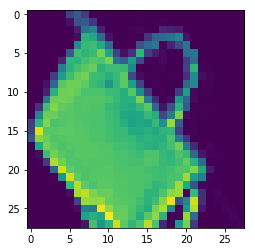

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(rez[0][:,:,0])

In [52]:
# add with tf.device('/gpu:0'): if on GPU

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))


model.add(Conv2D(64, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.1))


model.add(Conv2D(128, (3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(rate=0.1))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

# Dropout
model.add(Dropout(rate=0.5))
    
model.add(Dense(32, activation='relu'))
    

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [54]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')
# define path to save model
model_path = f'nn_results/colombia_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")

logdir = os.path.join("nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.75,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)

csv_logger = tf.keras.callbacks.CSVLogger(f'nn_results/training_{run_time_string}.log')

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, 
                                             patience=3, \
                                             verbose=1, mode='auto')

model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1)

model.fit_generator(image_generator,
          epochs=20,
          validation_data=(x_test.reshape(-1,28,28,1), Y_test), 
          callbacks=[tensorboard_callback, reduce_lr, csv_logger, earlystop, model_check])

Training ... nn_results/colombia_nn_2019-06-06T13:48.h5
Epoch 1/20
468/469 [============================>.] - ETA: 0s - loss: 0.5279 - accuracy: 0.8074
Epoch 00001: val_accuracy improved from -inf to 0.84440, saving model to nn_results/colombia_nn_2019-06-06T13:48.h5
469/469 [==============================] - 59s 126ms/step - loss: 0.5280 - accuracy: 0.8073 - val_loss: 0.4137 - val_accuracy: 0.8444
Epoch 2/20
362/469 [======================>.......] - ETA: 14s - loss: 0.4609 - accuracy: 0.8334

KeyboardInterrupt: 